# TESPy Introduction Tutorial

- General approach: Solve system of equations based on every connection's
  - mass flow $\dot m$,
  - pressure $p$,
  - enthalpy $h$ and
  - fluid composition $\vec x_i$

- All equations are applied implicitly, e.g. $0=\dot Q - \dot m \cdot \left( h_{out} - h_{in}\right)$
- Solver: Newton-Raphson method
- Value manipulation to respect physical fluid property boundaries

## Basic heat pump model

![Topology](heat_pump_basic.svg)

- Create a 4 component model of a heat pump using HeatExchangerSimple instances
- Specification of process and component parameters
- Fetch results
- Implement Busses for heat input, heat output and power input

In [1]:
from tespy.networks import Network
from tespy.components import Compressor, Valve, HeatExchangerSimple, CycleCloser, Sink, Source
from tespy.connections import Connection

nw = Network(fluids=['R134a'], p_unit='bar', T_unit='C', h_unit='kJ / kg')

cond = HeatExchangerSimple('Condenser')
exp_valve = Valve('Expansion valve')
evap = HeatExchangerSimple('Evaporator')
comp = Compressor('Compressor')
cc = CycleCloser('cycle closer')

so = Source('Dummy source')
si = Sink('Dummy sink')

In [2]:
c1 = Connection(so, 'out1', cond, 'in1', label='1')
c2 = Connection(cond, 'out1', si, 'in1', label='2')

nw.add_conns(c1, c2)

c1.set_attr(fluid={'R134a': 1}, T=100)
c2.set_attr(x=0, T=75)

cond.set_attr(pr=1, Q=-100e3)

In [3]:
nw.solve('design')
nw.print_results()

for df in nw.results.values():
    display(df)

iter	| residual | massflow | pressure | enthalpy | fluid
--------+----------+----------+----------+----------+---------
1	| 3.13e+05 | 4.43e+00 | 1.47e+06 | 1.61e+04 | 0.00e+00
2	| 1.94e+05 | 2.80e+00 | 4.11e+06 | 5.73e+04 | 0.00e+00
3	| 3.99e+04 | 3.65e+00 | 2.24e+06 | 3.93e+04 | 0.00e+00
4	| 1.52e+05 | 2.59e+00 | 1.46e+05 | 6.45e+04 | 0.00e+00
5	| 1.12e+05 | 1.05e+00 | 2.35e+03 | 3.44e+01 | 0.00e+00
6	| 1.80e+01 | 1.68e-04 | 7.10e-01 | 1.15e-02 | 0.00e+00
7	| 2.06e-06 | 1.57e-08 | 7.06e-02 | 1.93e-03 | 0.00e+00
--------+----------+----------+----------+----------+---------
Total iterations: 7, Calculation time: 0.1 s, Iterations per second: 129.58
##### RESULTS (HeatExchangerSimple) #####
+-----------+-----------+----------+----------+-----+-----+------+------+--------+
|           |         Q |       pr |     zeta |   D |   L |   ks |   kA |   Tamb |
|-----------+-----------+----------+----------+-----+-----+------+------+--------|
| Condenser | -1.00e+05 | 1.00e+00 | 0.00e+00 | nan

,m,p,h,T,v,vol,s,x,R134a
1,0.658905,23.6412,464.894638,100.0,0.006355,0.009645,1790.605732,-1.0,1.0
2,0.658905,23.6412,313.127777,75.0,0.000683,0.001037,1358.036148,0.0,1.0


""


,Q,pr,zeta,D,L,ks,kA,Tamb
Condenser,-100000.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN


""


In [4]:
c2.set_attr(T=None, p=20)
nw.solve('design', min_iter=10)
nw.print_results()

iter	| residual | massflow | pressure | enthalpy | fluid
--------+----------+----------+----------+----------+---------
1	| 3.64e+05 | 1.17e-01 | 3.64e+05 | 1.44e+04 | 0.00e+00
2	| 1.58e+03 | 1.47e-02 | 0.00e+00 | 3.42e+02 | 0.00e+00
3	| 3.55e+00 | 3.00e-05 | 0.00e+00 | 1.20e-01 | 0.00e+00
4	| 2.54e-06 | 2.12e-11 | 0.00e+00 | 1.49e-08 | 0.00e+00
5	| 1.92e-11 | 7.22e-14 | 0.00e+00 | 1.49e-08 | 0.00e+00
6	| 1.92e-11 | 7.22e-14 | 0.00e+00 | 1.49e-08 | 0.00e+00
7	| 1.92e-11 | 7.22e-14 | 0.00e+00 | 1.49e-08 | 0.00e+00
8	| 1.92e-11 | 7.22e-14 | 0.00e+00 | 1.49e-08 | 0.00e+00
9	| 1.92e-11 | 7.22e-14 | 0.00e+00 | 1.49e-08 | 0.00e+00
10	| 3.17e-11 | 7.21e-14 | 0.00e+00 | 1.49e-08 | 0.00e+00
11	| 1.25e-11 | 7.23e-14 | 0.00e+00 | 1.49e-08 | 0.00e+00
--------+----------+----------+----------+----------+---------
Total iterations: 11, Calculation time: 0.0 s, Iterations per second: 230.04
##### RESULTS (HeatExchangerSimple) #####
+-----------+-----------+----------+----------+-----+-----+------+---

In [5]:
nw.del_conns(c1, c2)

c1 = Connection(cc, 'out1', cond, 'in1', label='1')
c2 = Connection(cond, 'out1', exp_valve, 'in1', label='2')
c3 = Connection(exp_valve, 'out1', evap, 'in1', label='3')
c4 = Connection(evap, 'out1', comp, 'in1', label='4')
c5 = Connection(comp, 'out1', cc, 'in1', label='5')

nw.add_conns(c1, c2, c3, c4, c5)

In [6]:
c1.set_attr(fluid={'R134a': 1})
c2.set_attr(x=0, T=75)

c4.set_attr(x=1, T=10)

cond.set_attr(pr=1)
evap.set_attr(pr=1)
comp.set_attr(eta_s=0.9)

nw.solve('design')

nw.print_results()

for df in nw.results.values():
    display(df)

iter	| residual | massflow | pressure | enthalpy | fluid
--------+----------+----------+----------+----------+---------
1	| 8.20e+05 | 2.37e+01 | 3.60e+06 | 4.13e+05 | 0.00e+00
2	| 1.27e+06 | 1.61e+01 | 3.67e+06 | 1.62e+05 | 0.00e+00
3	| 2.94e+05 | 7.18e+00 | 5.51e+06 | 3.30e+04 | 0.00e+00
4	| 8.61e+04 | 1.17e-01 | 3.09e+05 | 9.12e+04 | 0.00e+00
5	| 3.48e+03 | 6.09e-02 | 9.86e+03 | 1.44e+02 | 0.00e+00
6	| 3.41e+00 | 5.95e-05 | 7.71e+00 | 1.09e-01 | 0.00e+00
7	| 1.70e-05 | 2.93e-07 | 1.50e+00 | 4.43e-02 | 0.00e+00
--------+----------+----------+----------+----------+---------
Total iterations: 7, Calculation time: 0.1 s, Iterations per second: 71.57
##### RESULTS (HeatExchangerSimple) #####
+------------+-----------+----------+----------+-----+-----+------+------+--------+
|            |         Q |       pr |     zeta |   D |   L |   ks |   kA |   Tamb |
|------------+-----------+----------+----------+-----+-----+------+------+--------|
| Condenser  | -1.00e+05 | 1.00e+00 | 0.00e+00 | 

,m,p,h,T,v,vol,s,x,R134a
1,0.764423,23.641200,443.945434,84.442255,0.006454,0.008443,1733.234990,-1.000000,1.0
2,0.764423,23.641200,313.127777,75.000000,0.000793,0.001037,1358.036148,0.000000,1.0
3,0.764423,4.146075,313.127777,10.000000,0.020015,0.026184,1400.054571,0.521915,1.0
4,0.764423,4.146075,404.318118,10.000000,0.037794,0.049442,1722.111224,1.000000,1.0
5,0.764423,23.641200,443.945434,84.442255,0.006454,0.008443,1733.234990,-1.000000,1.0


,mass_deviation,fluid_deviation


,Q,pr,zeta,D,L,ks,kA,Tamb
Condenser,-100000.000000,1.0,0.000000e+00,NaN,NaN,NaN,NaN,NaN
Evaporator,69707.975999,1.0,3.250008e-09,NaN,NaN,NaN,NaN,NaN


,pr,zeta
Expansion valve,0.175375,3.024104e+08


,P,eta_s,pr,igva
Compressor,30292.024001,0.9,5.702068,NaN


In [7]:
COP = abs(cond.Q.val) / comp.P.val
COP

3.301199021834831

## Parameter influence: Temperature levels & Working fluid

- Analysing parameter influence of temperature levels
- Make the working fluid interchangable

In [8]:
import numpy as np
from matplotlib import pyplot as plt

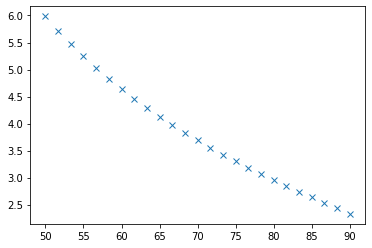

In [9]:
T_range = np.linspace(50, 90, 25)
nw.set_attr(iterinfo=False)

COP_list = []

for T in T_range:
    c2.set_attr(T=T)
    nw.solve('design')
    COP_list += [abs(cond.Q.val) / comp.P.val]
    
plt.plot(T_range, COP_list, 'x')

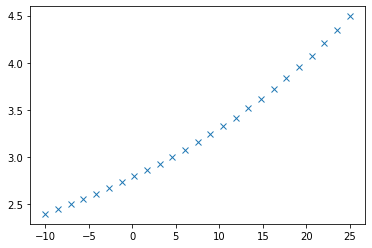

In [10]:
T_range = np.linspace(-10, 25, 25)
nw.set_attr(iterinfo=False)
c2.set_attr(T=75)

COP_list = []

for T in T_range:
    c4.set_attr(T=T)
    nw.solve('design')
    COP_list += [abs(cond.Q.val) / comp.P.val]
    
plt.plot(T_range, COP_list, 'x')

In [11]:
from tespy.tools import document_model
document_model(nw)

In [12]:
def get_nw_by_wf(working_fluid):
    
    nw = Network(fluids=[working_fluid], p_unit='bar', T_unit='C', h_unit='kJ / kg')

    cond = HeatExchangerSimple('Condenser')
    exp_valve = Valve('Expansion valve')
    evap = HeatExchangerSimple('Evaporator')
    comp = Compressor('Compressor')
    cc = CycleCloser('cycle closer')
    
    
    c1 = Connection(cc, 'out1', cond, 'in1', label='1')
    c2 = Connection(cond, 'out1', exp_valve, 'in1', label='2')
    c3 = Connection(exp_valve, 'out1', evap, 'in1', label='3')
    c4 = Connection(evap, 'out1', comp, 'in1', label='4')
    c5 = Connection(comp, 'out1', cc, 'in1', label='5')

    nw.add_conns(c1, c2, c3, c4, c5)
    
    c1.set_attr(fluid={working_fluid: 1})
    c2.set_attr(x=0, T=75)

    c4.set_attr(x=1, T=10)

    cond.set_attr(pr=1, Q=-100e3)
    evap.set_attr(pr=1)
    comp.set_attr(eta_s=0.9)
    
    nw.set_attr(iterinfo=False)
    
    return nw

for wf in ['R134a', 'R600', 'NH3', 'Isopentane', 'water', 'butane']:
    mynetwork = get_nw_by_wf(wf)
    mynetwork.solve('design')
    
    power = mynetwork.get_comp('Compressor').P.val
    heat = mynetwork.get_comp('Condenser').Q.val
    

## Extend heat pump model with heat sink/source systems

![Topology](heat_pump_extended.svg)


- Add circulation system for consumer side
- Add heat source side (pump/fan)

In [13]:
from tespy.components import HeatExchanger, Condenser

nw = Network(fluids=['R134a', 'Air', 'water'], p_unit='bar', T_unit='C', h_unit='kJ / kg')

cond = Condenser('Condenser')
exp_valve = Valve('Expansion valve')
evap = HeatExchanger('Evaporator')
comp = Compressor('Compressor')
cc = CycleCloser('cycle closer')

so_air = Source('Ambient air source')
si_air = Sink('Ambient air sink')
so_cons = Source('Consumer source')
si_cons = Sink('Consumer sink')

c1 = Connection(cc, 'out1', cond, 'in1', label='1')
c2 = Connection(cond, 'out1', exp_valve, 'in1', label='2')
c3 = Connection(exp_valve, 'out1', evap, 'in2', label='3')
c4 = Connection(evap, 'out2', comp, 'in1', label='4')
c5 = Connection(comp, 'out1', cc, 'in1', label='5')

nw.add_conns(c1, c2, c3, c4, c5)

c11 = Connection(so_cons, 'out1', cond, 'in2', label='11') # default label: Consumer source:out1_Condenser:in2
c12 = Connection(cond, 'out2', si_cons, 'in1', label='12')

c21 = Connection(so_air, 'out1', evap, 'in1', label='21')
c22 = Connection(evap, 'out1', si_air, 'in1', label='22')

nw.add_conns(c11, c12, c21, c22)

c1.set_attr(fluid={'R134a': 1, 'Air': 0, 'water': 0})
c2.set_attr(T=75)

c4.set_attr(x=1, T=10, design=['T'])

cond.set_attr(pr1=1, pr2=1, Q=-100e3, offdesign=['kA_char'])
evap.set_attr(pr1=1, pr2=1, offdesign=['kA_char'])
comp.set_attr(eta_s=0.9, design=['eta_s'], offdesign=['eta_s_char'])

c11.set_attr(fluid={'R134a': 0, 'Air': 0, 'water': 1}, T=50, p=5)
c12.set_attr(T=70, design=['T'])

c21.set_attr(fluid={'R134a': 0, 'Air': 1, 'water': 0}, T=20, p=1)
c22.set_attr(T=15)

nw.set_attr(iterinfo=False)

nw.solve('design')
nw.print_results()
nw.save('design_state')

nw.solve('offdesign', design_path='design_state')
document_model(nw)

cond.set_attr(Q=-110e3)

nw.solve('offdesign', design_path='design_state')
nw.print_results()

##### RESULTS (Condenser) #####
+-----------+-----------+----------+----------+----------+----------+----------+----------+----------+----------+
|           |         Q |       kA |   td_log |    ttd_u |    ttd_l |      pr1 |      pr2 |    zeta1 |    zeta2 |
|-----------+-----------+----------+----------+----------+----------+----------+----------+----------+----------|
| Condenser | -1.00e+05 | 8.05e+03 |      nan | 5.00e+00 | 2.50e+01 | 1.00e+00 | 1.00e+00 | 0.00e+00 | 0.00e+00 |
+-----------+-----------+----------+----------+----------+----------+----------+----------+----------+----------+
##### RESULTS (Valve) #####
+-----------------+----------+----------+
|                 |       pr |     zeta |
|-----------------+----------+----------|
| Expansion valve | 1.75e-01 | 3.02e+08 |
+-----------------+----------+----------+
##### RESULTS (HeatExchanger) #####
+------------+-----------+----------+----------+----------+----------+----------+----------+----------+----------+
|        

## Influence of heat source medium

- Investigation of heat source medium on COP

## Misc: Exergy analysis, ...

- Run the exergy analysis
- Create Grassmann Graph
- ...

In [14]:
import plotly.graph_objects as go

fig = go.Figure(go.Sankey(
    arrangement="snap",
    node={
        "label": nodes,
        'pad': 11,
        'color': 'orange'},
    link=links))
fig.show()

NameError: name 'nodes' is not defined